In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from datetime import datetime as dt

import tensorflow as tf
from tensorflow import keras

from module import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

# 1. Data
- 해당의 데이터는 movielens 데이터이며, train_test_split 으로 나누어져 훈련용, 시험용 데이터로 나누어진다.
- generate_trainset, generate_testset 으로 인해 반환되는 값은 numpy array의 형식으로 X, y 로 반환된다.

In [3]:
loader = DataLoader()

X_train, y_train = loader.generate_trainset()
X_test, y_test = loader.generate_testset()

print("훈련 데이터 shape : {}, 훈련 라벨 갯수 : {}".format(X_train.shape, y_train.size))
print("테스트 데이터 shape : {}, 테스트 라벨 갯수 : {}".format(X_test.shape, y_test.size))

훈련 데이터 shape : (80003, 2), 훈련 라벨 갯수 : 80003
테스트 데이터 shape : (19259, 2), 테스트 라벨 갯수 : 19259


# 2. Neural Collaborative Filtering (Neural CF)

## 1. Generate Neural CF Model Process

In [4]:
# 1. Setting Value

# Global
num_users = loader.num_users
num_items = loader.num_items
regs = 0

# GMF Setting
latent_features = 8

# MLP Setting
layers = list(map(int, [64,32,16,8]))
num_layers = len(layers)

In [11]:
# 2. 입력 층 생성
user_input = keras.Input(shape=(1,), dtype='int32')
item_input = keras.Input(shape=(1,), dtype='int32')

In [17]:
# 3-1. GMF Layer Group 생성 (embedding -> flatten -> multiply)
user_model_gmf = keras.Sequential()
item_model_gmf = keras.Sequential()

user_model_gmf.add(user_input)
item_model_gmf.add(item_input)

# 3-1-1. embedding
user_embedding_gmf = keras.layers.Embedding(
                    num_users,
                    latent_features,
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='user_emebedding')
item_embedding_gmf = keras.layers.Embedding(
                    num_items,
                    latent_features,
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='item_emebedding')
user_model_gmf.add(user_embedding_gmf)
item_model_gmf.add(item_embedding_gmf)


# 3-1-2. flatten
user_latent_gmf = keras.layers.Flatten()
item_latent_gmf = keras.layers.Flatten()
user_model_gmf.add(user_latent_gmf)
item_model_gmf.add(item_latent_gmf)

# 3-1-3. multiply
user_output_gmf = user_model_gmf(X_train[:, 0])
item_output_gmf = item_model_gmf(X_train[:, 1])
concat = keras.layers.Multiply()
gmf_result = concat([user_output_gmf, item_output_gmf])

print("---- 사용자 X 아이템 ----")
print("입력 값: {}".format(X_train[0, 0], X_train[0, 1]))
print("GMF 출력 값: {}".format(gmf_result[0].numpy()))
print("훈련 데이터 shape: {}\n".format(gmf_result.shape))

---- 사용자 X 아이템 ----
입력 값: 0
GMF 출력 값: [ 1.6539261e-05 -3.5399414e-04 -4.5457669e-04  1.1783070e-04
 -2.7766862e-04  4.4984816e-04 -2.1152396e-04 -1.0644225e-03]
훈련 데이터 shape: (80003, 8)



In [18]:
# 3-2. MLP Layer Group 생성 (embedding -> flatten -> concatenate -> hidden layers)
user_model_mlp = keras.Sequential()
item_model_mlp = keras.Sequential()

user_model_mlp.add(user_input)
item_model_mlp.add(item_input)

# 3-2-1. embedding
user_embedding_mlp = keras.layers.Embedding(
                    num_users,
                    int(layers[0] / 2),
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='user_emebedding')
item_embedding_mlp = keras.layers.Embedding(
                    num_items,
                    int(layers[0] / 2),
                    embeddings_regularizer=keras.regularizers.l2(regs),
                    name='item_emebedding')
user_model_mlp.add(user_embedding_mlp)
item_model_mlp.add(item_embedding_mlp)

# 3-2-2. flatten
user_latent_mlp = keras.layers.Flatten()
item_latent_mlp = keras.layers.Flatten()
user_model_mlp.add(user_latent_mlp)
item_model_mlp.add(item_latent_mlp)

# 3-2-3. concatenate
user_output_mlp = user_model_mlp(X_train[:, 0])
item_output_mlp = item_model_mlp(X_train[:, 1])
vector = keras.layers.Concatenate()
concatenates_output = vector([user_output_mlp, item_output_mlp])

# 3-2-4. hidden layers
hidden_model = keras.Sequential()
for index in range(num_layers):
    hidden_layer = keras.layers.Dense(
                    layers[index],
                    kernel_regularizer=keras.regularizers.l2(regs),
                    activation = keras.activations.relu,
                    name = "layer_{}".format(index)
                   )
    hidden_model.add(hidden_layer)
mlp_result = hidden_model(concatenates_output)

print("---- 사용자 X 아이템 ----")
print("입력 값: {}".format(X_train[0, 0], X_train[0, 1]))
print("MLP 출력 값: {}".format(mlp_result[0].numpy()))
print("훈련 데이터 shape: {}\n".format(mlp_result.shape))

---- 사용자 X 아이템 ----
입력 값: 0
MLP 출력 값: [0.00828632 0.         0.01420904 0.02250351 0.00087989 0.01574119
 0.         0.00567012]
훈련 데이터 shape: (80003, 8)



In [24]:
# 4. concat GMF output and MLP output
concat_neural = keras.layers.Concatenate()
concat_neural = concat_neural([gmf_result, mlp_result])

print("---- GMF X MLP ----")
print("입력 값: {}".format(X_train[0, 0], X_train[0, 1]))
print("MLP 출력 값: {}".format(concat_neural[0].numpy()))
print("훈련 데이터 shape: {}\n".format(concat_neural.shape))

---- GMF X MLP ----
입력 값: 0
MLP 출력 값: [ 1.6539261e-05 -3.5399414e-04 -4.5457669e-04  1.1783070e-04
 -2.7766862e-04  4.4984816e-04 -2.1152396e-04 -1.0644225e-03
  8.2863234e-03  0.0000000e+00  1.4209044e-02  2.2503514e-02
  8.7989063e-04  1.5741188e-02  0.0000000e+00  5.6701186e-03]
훈련 데이터 shape: (80003, 16)



In [29]:
# 5. Dense Layer
output = keras.layers.Dense(1, kernel_initializer=keras.initializers.lecun_uniform(),name='output')
result = output(concat_neural)

print("---- Neural CF 는 GMF가 학습하는 선형적 관계와 MLP가 학습하는 비선형적 관계를 이용하여 학습한다. ----")
print(result.numpy())

---- Neural CF 는 GMF가 학습하는 선형적 관계와 MLP가 학습하는 비선형적 관계를 이용하여 학습한다. ----
[[0.00469078]
 [0.00045272]
 [0.00077031]
 ...
 [0.00121713]
 [0.00384654]
 [0.00874607]]


## 2. Use

In [34]:
# 1. model setting
from model import NeuralMF
model = NeuralMF(loader.num_users, loader.num_items).get_model()

In [35]:
# 2. Callbacks
early_stop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# model_out_file = 'Pretrain/GMF_%s.h5' % (datetime.now().strftime('%Y-%m-%d-%h-%m-%s'))
# model_check_cb = keras.callbacks.ModelCheckpoint(model_out_file, save_best_only=True)

In [36]:
# 3. Compile
learner = "adam"
learning_rate = 0.001

if learner == "adagrad":
    model.compile(optimizer=keras.optimizers.Adagrad(learning_rate=learning_rate), loss='mse')
elif learner == "rmsprop":
    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate), loss='mse')
elif learner == "adam":
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
else:
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate), loss='mse')

In [37]:
# 4. Train
epochs = 20
batch_size = 256

history = model.fit(
            [X_train[:, 0], X_train[:, 1]], y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
            callbacks=[early_stop_cb]
        )

Epoch 1/20
313/313 [==============================] - 2s 4ms/step - loss: 2.4469 - val_loss: 0.8103
Epoch 2/20
313/313 [==============================] - 1s 3ms/step - loss: 0.7629 - val_loss: 0.7966
Epoch 3/20
313/313 [==============================] - 1s 3ms/step - loss: 0.7145 - val_loss: 0.7891
Epoch 4/20
313/313 [==============================] - 1s 3ms/step - loss: 0.6361 - val_loss: 0.7778
Epoch 5/20
313/313 [==============================] - 1s 3ms/step - loss: 0.5429 - val_loss: 0.8062
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.4784 - val_loss: 0.8177
Epoch 7/20
313/313 [==============================] - 1s 4ms/step - loss: 0.4336 - val_loss: 0.8443
Epoch 8/20
313/313 [==============================] - 1s 4ms/step - loss: 0.3998 - val_loss: 0.8686
Epoch 9/20
313/313 [==============================] - 1s 5ms/step - loss: 0.3727 - val_loss: 0.8889
Epoch 10/20
313/313 [==============================] - 1s 4ms/step - loss: 0.3489 - val_loss: 0.9097

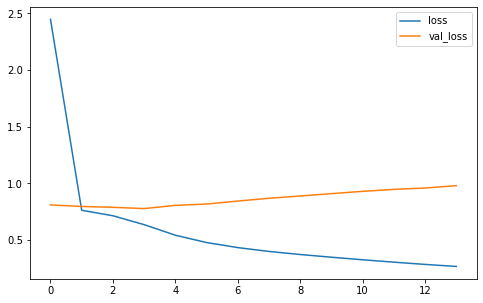

[4.2739635 3.3085968 3.4045603 3.4682746 4.165092  3.7340648 3.7352898
 3.1309288 3.597696  2.2557669]
[5. 3. 4. 4. 5. 5. 5. 3. 4. 2.]


In [38]:
# 5. Result
pd.DataFrame(history.history).plot(figsize= (8,5))
plt.show()
test_sample = X_test[:10]
test_sample_label = y_test[:10]
print(model.predict([test_sample[:, 0], test_sample[:, 1]]).flatten())
print(test_sample_label)